# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

# Get Required Files from Drive

In [ ]:
# Mount Colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab/Great Lakes Projects/Project 11 - NLP/GL Data'

In [ ]:
!ls

drive  sample_data


# Step 1 : Import the Dependencies/ neccesary Libraries

In [ ]:
# Import Dependencies
import numpy as np 
import pandas as pd 

import os
import re

import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# For Embedding Layer
from keras.layers.embeddings import Embedding

# For RNN Layer
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Bidirectional
from keras.layers import Dense, Dropout, Activation

# For CNN Layer
from keras.layers import Conv1D, MaxPooling1D

# For Text Summarization
from gensim.summarization import summarize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Step 2. Import JSON Data and create Dataframe

In [ ]:
# Import Files
twitter_df = pd.read_json('/content/drive/My Drive/Colab/Great Lakes Projects/Project 11 - NLP/GL Data/Sarcasm_Headlines_Dataset.json', lines = True)

In [ ]:
twitter_df.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


# Step 3 : Basic EDA about headline length

In [ ]:
print("----"*20)
print("Total number of headlines given in Data is ",len(twitter_df))
print("----"*20)

--------------------------------------------------------------------------------
Total number of headlines given in Data is  26709
--------------------------------------------------------------------------------


In [ ]:
# Check for any null values
print("----"*20)
print("Total number of missing values in headlines is ", twitter_df['headline'].isnull().sum())
print("----"*20)

--------------------------------------------------------------------------------
Total number of missing values in headlines is  0
--------------------------------------------------------------------------------


In [ ]:
# Creating a feature that will contain respective length of  headlines

twitter_df['headline_length'] = twitter_df['headline'].str.len() # or the below code
#twitter_df['headline_length'] = twitter_tf['headline'].apply(len)

In [ ]:
print("----"*20)
print("The Mean of Headline Length in Given Data is ", twitter_df['headline_length'].mean())
print("----"*20)

--------------------------------------------------------------------------------
The Mean of Headline Length in Given Data is  60.910591935302705
--------------------------------------------------------------------------------


In [ ]:
# Mean and Max Values of Comments
twitter_df['headline_length'].describe()

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64

## ======================== NOTE ===========================
### Hence, the Max Length Headline has 254 characters and minimum length headline has 7 Characters

### They are as follows :
## ==========================================================

In [ ]:
# Headline with 
headline_length = twitter_df.headline.astype(str).map(len)

print("----"*20)
print("########################## This is the longest headline #############################")
print (twitter_df.loc[headline_length.idxmax(), 'headline'])

print("\n", "----"*20)
print("########################## This is the shortest headline ###########################")
print (twitter_df.loc[headline_length.idxmin(), 'headline'])
print("----"*20)

--------------------------------------------------------------------------------
########################## This is the longest headline #############################
maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86

 --------------------------------------------------------------------------------
########################## This is the shortest headline ###########################
bye bye
--------------------------------------------------------------------------------


## Headline_length EDA

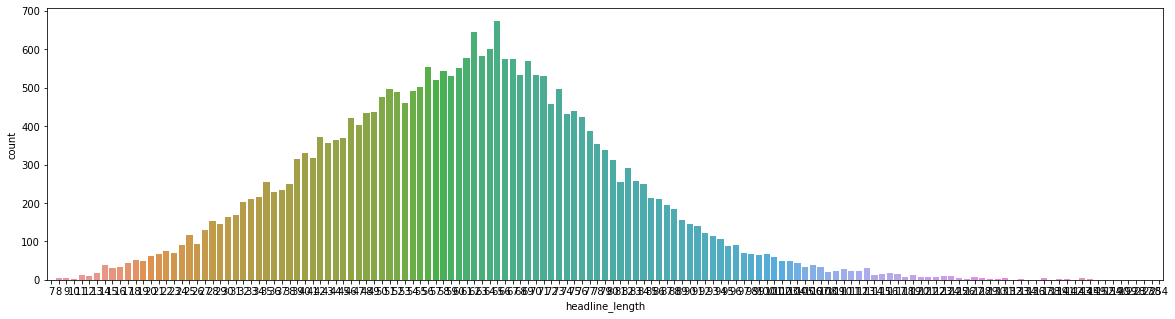

In [ ]:
# Distribution of Headline_Length
plt.figure(figsize=(20,5))
sns.countplot(x="headline_length", data=twitter_df)

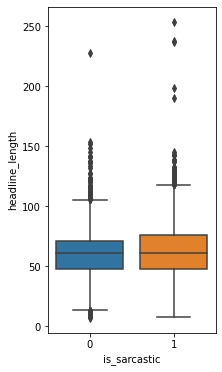

In [ ]:
# Distribution of Comments w.r.t. is_sarcastic values 
plt.figure(figsize=(3,6))
sns.boxplot(x='is_sarcastic', y = twitter_df['headline_length'], data=twitter_df)

# Step 4 : Dropping article_link and headline_length feature after EDA

In [ ]:
# Now we will drop the article_link and headline_length column from twitter_df as it dont add relevance in model creation
twitter_df = twitter_df.drop(['article_link',  'headline_length'], axis = 1)

# Step 5 : Clean the Data

In [ ]:
import requests
from bs4 import BeautifulSoup 
'''
def preprocess_text(text):
    """ Apply any preprocessing methods"""
    text = BeautifulSoup(text).get_text()
    text = text.lower()
    text = text.replace('[^\w\s]','')
    return text
    '''
def preprocess_text(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

twitter_df['headline'] = preprocess_text(twitter_df['headline'])

# twitter_df["headline"] = twitter_df.headline.apply(preprocess_text)

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))
#not is in the stopword list. W/O adding whitelist, the summary would change from "do not recommend" to "recommend". This solution was borrowed from bertcarremans https://github.com/bertcarremans/TwitterUSAirlineSentiment

whitelist = ["n't", "not", "no"]

twitter_df['headline_after_removed_stopwords'] = twitter_df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word in whitelist or word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print("----"*20)
print('### Sample Headline after removed stopwords###'+'\n'+twitter_df['headline_after_removed_stopwords'][1])
print("----"*20)
print('### Sample Headline before removed stopwords###'+'\n'+ twitter_df['headline'][1])

--------------------------------------------------------------------------------
### Sample Headline after removed stopwords###
'roseanne' revival catches thorny political mood, better worse
--------------------------------------------------------------------------------
### Sample Headline before removed stopwords###
the 'roseanne' revival catches up to our thorny political mood, for better and worse


In [ ]:
# This Block of code adds contractions to the headline

# We are commenting it out as it dosen't leads to any accuracy improvement

'''
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}
'''

'\n# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python\ncontractions = { \n"ain\'t": "am not",\n"aren\'t": "are not",\n"can\'t": "cannot",\n"can\'t\'ve": "cannot have",\n"\'cause": "because",\n"could\'ve": "could have",\n"couldn\'t": "could not",\n"couldn\'t\'ve": "could not have",\n"didn\'t": "did not",\n"doesn\'t": "does not",\n"don\'t": "do not",\n"hadn\'t": "had not",\n"hadn\'t\'ve": "had not have",\n"hasn\'t": "has not",\n"haven\'t": "have not",\n"he\'d": "he would",\n"he\'d\'ve": "he would have",\n"he\'ll": "he will",\n"he\'s": "he is",\n"how\'d": "how did",\n"how\'ll": "how will",\n"how\'s": "how is",\n"i\'d": "i would",\n"i\'ll": "i will",\n"i\'m": "i am",\n"i\'ve": "i have",\n"isn\'t": "is not",\n"it\'d": "it would",\n"it\'ll": "it will",\n"it\'s": "it is",\n"let\'s": "let us",\n"ma\'am": "madam",\n"mayn\'t": "may not",\n"might\'ve": "might have",\n"mightn\'t": "might not",\n"must\'ve": "must have",\n"must

In [ ]:
# We are commenting it out as it dosen't leads to any accuracy improvement
'''
#This two blocks of code was refered from https://www.kaggle.com/currie32/summarizing-text-with-amazon-reviews
def clean_text(text):

    # Replace contractions with longer forms in the above list
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
'''

'\n#This two blocks of code was refered from https://www.kaggle.com/currie32/summarizing-text-with-amazon-reviews\ndef clean_text(text):\n\n    # Replace contractions with longer forms in the above list\n    if True:\n        text = text.split()\n        new_text = []\n        for word in text:\n            if word in contractions:\n                new_text.append(contractions[word])\n            else:\n                new_text.append(word)\n'

In [ ]:

def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text


In [ ]:
twitter_df.head()

,headline,is_sarcastic,headline_after_removed_stopwords
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...
1,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...
2,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...
3,"boehner just wants wife to listen, not come up...",1,"boehner wants wife listen, not come alternativ..."
4,j.k. rowling wishes snape happy birthday in th...,0,j.k. rowling wishes snape happy birthday magic...


In [ ]:
clean_summaries = []
for summary in twitter_df.headline_after_removed_stopwords:
    clean_summaries.append(clean_text(summary))
    pass
print("Summaries are complete.")

print(len(clean_summaries))

Summaries are complete.
26709


In [ ]:
twitter_df.head()

,headline,is_sarcastic,headline_after_removed_stopwords
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...
1,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...
2,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...
3,"boehner just wants wife to listen, not come up...",1,"boehner wants wife listen, not come alternativ..."
4,j.k. rowling wishes snape happy birthday in th...,0,j.k. rowling wishes snape happy birthday magic...


In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(twitter_df)
head_lines[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

# Step 6 : Visualize the most occuring words

(-0.5, 999.5, 499.5, -0.5)

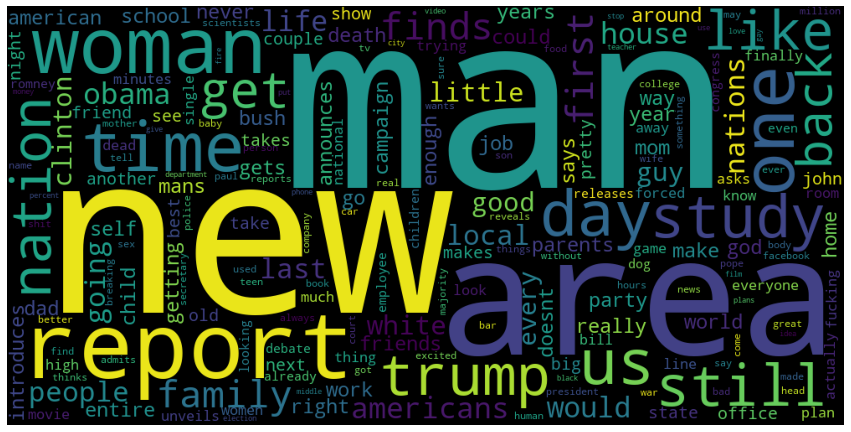

In [ ]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = twitter_df.loc[twitter_df['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")


# Step 7  :Creating the Train and Test split

In [ ]:
validation_split = 0.3
max_length = 30


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  twitter_df['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  27483
vocab size - 27484


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (18697, 30)
Shape of y_train: (18697,)
Shape of X_test_pad: (8012, 30)
Shape of y_test: (8012,)


# Step 7 : Importing Pre-trained GloVe Model

In [ ]:
embeddings_index = {}
embedding_dim = 100

GLOVE_DIR = "/content/drive/My Drive/Colab/Great Lakes Projects/Project 11 - NLP/GL Data"

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Step 8 : Importing GloVe and Building the Embedding Layer/Matrix

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24011


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# Step 9 : Building and Training the RNN

In [ ]:
# Convolution Params
kernel_size = 5
filters = 64
pool_size = 4
activation_func = 'sigmoid'


# LSTM/GRU/Bi-directional LSTM Params
seq_output_size = 128

# Training Params
batch_size = 32
epochs = 25

### 9(a). Model with (( GloVe + Single LSTM )) Layer

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(seq_output_size, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           2748400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,865,777
Trainable params: 117,377
Non-trainable params: 2,748,400
_________________________________________________________________
None


In [ ]:
history_single_lstm = model.fit(X_train_pad, y_train, 
                                batch_size=batch_size, 
                                epochs=epochs, 
                                validation_data=(X_test_pad, y_test), 
                                verbose=2)

Train on 18697 samples, validate on 8012 samples
Epoch 1/25
 - 25s - loss: 0.6034 - acc: 0.6805 - val_loss: 0.5285 - val_acc: 0.7456
Epoch 2/25
 - 24s - loss: 0.5533 - acc: 0.7286 - val_loss: 0.5079 - val_acc: 0.7580
Epoch 3/25
 - 24s - loss: 0.5232 - acc: 0.7473 - val_loss: 0.4735 - val_acc: 0.7827
Epoch 4/25
 - 24s - loss: 0.5015 - acc: 0.7604 - val_loss: 0.4665 - val_acc: 0.7793
Epoch 5/25
 - 24s - loss: 0.4806 - acc: 0.7762 - val_loss: 0.4711 - val_acc: 0.7831
Epoch 6/25
 - 24s - loss: 0.4636 - acc: 0.7826 - val_loss: 0.4311 - val_acc: 0.8022
Epoch 7/25
 - 24s - loss: 0.4469 - acc: 0.7914 - val_loss: 0.4285 - val_acc: 0.8009
Epoch 8/25
 - 24s - loss: 0.4379 - acc: 0.8019 - val_loss: 0.4172 - val_acc: 0.8084
Epoch 9/25
 - 24s - loss: 0.4236 - acc: 0.8049 - val_loss: 0.4087 - val_acc: 0.8130
Epoch 10/25
 - 24s - loss: 0.4094 - acc: 0.8170 - val_loss: 0.4068 - val_acc: 0.8127
Epoch 11/25
 - 24s - loss: 0.3975 - acc: 0.8223 - val_loss: 0.3964 - val_acc: 0.8176
Epoch 12/25
 - 24s - loss

In [ ]:
single_lstm_score, single_lstm_acc = model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print("---"*20)
print('Single LSTM Test score:', single_lstm_score)
print('Single LSTM Test accuracy:', single_lstm_acc)

8012/8012 [==============================] - 3s 345us/step
------------------------------------------------------------
Single LSTM Test score: 0.3794403298610577
Single LSTM Test accuracy: 0.8354967832565308


### 6(b). Model with (( GloVe + LSTM + Conv1D + Maxpool )) Unit Layers

In [ ]:
print('Build model...')

# Adding Embedding Layer
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(Dropout(0.2))
lstm_model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# Adding LSTM Layer
lstm_model.add(MaxPooling1D(pool_size=pool_size))
lstm_model.add(LSTM(seq_output_size, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1))
lstm_model.add(Activation('sigmoid'))


# Creating Layer
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



Build model...


In [ ]:
print('Train...')
lstm_model.fit(X_train_pad, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_pad, y_test),
          verbose=2)

Train...
Train on 18697 samples, validate on 8012 samples
Epoch 1/25
 - 11s - loss: 0.5867 - accuracy: 0.6894 - val_loss: 0.5477 - val_accuracy: 0.7239
Epoch 2/25
 - 10s - loss: 0.5206 - accuracy: 0.7428 - val_loss: 0.4796 - val_accuracy: 0.7683
Epoch 3/25
 - 10s - loss: 0.4841 - accuracy: 0.7704 - val_loss: 0.4704 - val_accuracy: 0.7721
Epoch 4/25
 - 10s - loss: 0.4559 - accuracy: 0.7851 - val_loss: 0.4522 - val_accuracy: 0.7863
Epoch 5/25
 - 10s - loss: 0.4319 - accuracy: 0.8022 - val_loss: 0.4569 - val_accuracy: 0.7795
Epoch 6/25
 - 10s - loss: 0.4086 - accuracy: 0.8159 - val_loss: 0.4537 - val_accuracy: 0.7821
Epoch 7/25
 - 10s - loss: 0.3948 - accuracy: 0.8199 - val_loss: 0.4475 - val_accuracy: 0.7844
Epoch 8/25
 - 10s - loss: 0.3775 - accuracy: 0.8328 - val_loss: 0.4552 - val_accuracy: 0.7822
Epoch 9/25
 - 10s - loss: 0.3608 - accuracy: 0.8423 - val_loss: 0.4600 - val_accuracy: 0.7826
Epoch 10/25
 - 10s - loss: 0.3523 - accuracy: 0.8412 - val_loss: 0.4545 - val_accuracy: 0.7871
E

In [ ]:
lstm_score, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print("---"*20)
print('LSTM Test score:', lstm_score)
print('LSTM Test accuracy:', lstm_acc)

8012/8012 [==============================] - 1s 144us/step
------------------------------------------------------------
LSTM Test score: 0.4738268490231638
LSTM Test accuracy: 0.7859460711479187


### 6(c). Model with (( GloVe + GRU + Conv1D + Maxpool )) Unit Layers

In [ ]:
print('Build GRU based model...')

# Adding Embedding Layer
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(Dropout(0.2))
gru_model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# Adding GRU Layer
gru_model.add(MaxPooling1D(pool_size=pool_size))
gru_model.add(GRU(seq_output_size, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1))
gru_model.add(Activation('sigmoid'))


# Creating Layer
gru_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build GRU based model...


In [ ]:
print('Train...')
gru_model.fit(X_train_pad, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_pad, y_test))

Train...
Train on 18697 samples, validate on 8012 samples
Epoch 1/25
18697/18697 [==============================] - 13s 694us/step - loss: 0.5958 - accuracy: 0.6832 - val_loss: 0.5683 - val_accuracy: 0.7124
Epoch 2/25
18697/18697 [==============================] - 12s 660us/step - loss: 0.5246 - accuracy: 0.7461 - val_loss: 0.5171 - val_accuracy: 0.7435
Epoch 3/25
18697/18697 [==============================] - 12s 654us/step - loss: 0.4829 - accuracy: 0.7672 - val_loss: 0.5566 - val_accuracy: 0.6923
Epoch 4/25
18697/18697 [==============================] - 12s 651us/step - loss: 0.4515 - accuracy: 0.7875 - val_loss: 0.5091 - val_accuracy: 0.7459
Epoch 5/25
18697/18697 [==============================] - 12s 649us/step - loss: 0.4295 - accuracy: 0.8023 - val_loss: 0.5173 - val_accuracy: 0.7363
Epoch 6/25
18697/18697 [==============================] - 12s 655us/step - loss: 0.4102 - accuracy: 0.8120 - val_loss: 0.5232 - val_accuracy: 0.7475
Epoch 7/25
18697/18697 [========================

In [ ]:
gru_score, gru_acc = gru_model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print("---"*20)
print('GRU Test score:', gru_score)
print('GRU Test accuracy:', gru_acc)

8012/8012 [==============================] - 1s 127us/step
------------------------------------------------------------
GRU Test score: 0.4770043606735502
GRU Test accuracy: 0.7765851020812988


### 6(d). Model with (( GloVe + Bi-Directional LSTM + Conv1D + Maxpool )) Unit Layers

In [ ]:
print('Build Bi Directional LSTM model...')

# Adding Embedding Layer
bi_model = Sequential()
bi_model.add(embedding_layer)
bi_model.add(Dropout(0.4))
bi_model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# Adding GRU Layer
bi_model.add(MaxPooling1D(pool_size=pool_size))
bi_model.add(Bidirectional(LSTM(seq_output_size, dropout=0.2, recurrent_dropout=0.2)))
bi_model.add(Dense(1))
bi_model.add(Activation('sigmoid'))


# Creating Layer
bi_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build Bi Directional LSTM model...


In [ ]:
print('Train...')
bi_model.fit(X_train_pad, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_pad, y_test))

Train...
Train on 18697 samples, validate on 8012 samples
Epoch 1/25
18697/18697 [==============================] - 16s 881us/step - loss: 0.6007 - accuracy: 0.6782 - val_loss: 0.5418 - val_accuracy: 0.7384
Epoch 2/25
18697/18697 [==============================] - 15s 811us/step - loss: 0.5457 - accuracy: 0.7262 - val_loss: 0.5010 - val_accuracy: 0.7532
Epoch 3/25
18697/18697 [==============================] - 15s 814us/step - loss: 0.5175 - accuracy: 0.7456 - val_loss: 0.4933 - val_accuracy: 0.7555
Epoch 4/25
18697/18697 [==============================] - 15s 816us/step - loss: 0.4926 - accuracy: 0.7603 - val_loss: 0.4598 - val_accuracy: 0.7802
Epoch 5/25
18697/18697 [==============================] - 15s 821us/step - loss: 0.4798 - accuracy: 0.7709 - val_loss: 0.4633 - val_accuracy: 0.7807
Epoch 6/25
18697/18697 [==============================] - 15s 818us/step - loss: 0.4627 - accuracy: 0.7788 - val_loss: 0.4482 - val_accuracy: 0.7884
Epoch 7/25
18697/18697 [========================

In [ ]:
bi_score, bi_acc = bi_model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print("---"*20)
print('Bi-Directional LSTM Test score:', bi_score)
print('Bi-Directional LSTM Test accuracy:', bi_acc)

8012/8012 [==============================] - 1s 161us/step
------------------------------------------------------------
Bi-Directional LSTM Test score: 0.44844290243644924
Bi-Directional LSTM Test accuracy: 0.7878182530403137


# Checking Clasas Level Accuracy with Confusion Matrix

In [ ]:
pred = model.predict_classes(X_test_pad)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)

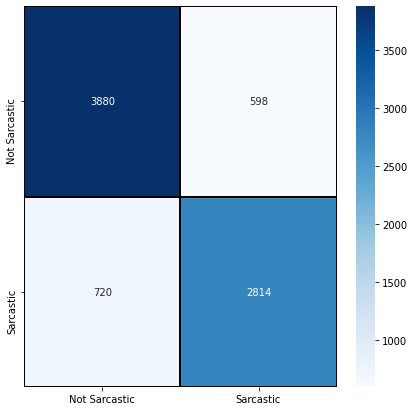

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='' , 
            xticklabels = ['Not Sarcastic','Sarcastic'] , 
            yticklabels = ['Not Sarcastic','Sarcastic'])

-----------------
# Can this model detect sarcasms?
-----------------

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

### Correct Predictions

In [ ]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's a sarcasm!"

In [ ]:
predict_sarcasm("You just broke my car window. Great job.")

"It's a sarcasm!"

In [ ]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("I want a million dollars!")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("I just won a million dollars!")

"It's a sarcasm!"

### Incorrect Predictions

In [ ]:
predict_sarcasm("His name is Bob. He is a nice person.")

"It's a sarcasm!"

In [ ]:
predict_sarcasm("Sarcasm is very easy to detect.")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("It was so easy that no one was able do it")

"It's not a sarcasm."

# =======================CONCLUSION =========================

# 1. We implemented the GloVe Embedding(with 300d) with only LSTM as they are best performing. 

# 2. The Simple LSTM model are better performing because in all the rest models the numbers of trainable params are huge which is causing the Models to overfit and perform poor on validation/test data. 

# 3. Sarcastic Class level accuracy is 79.62 % i.e. 598 Non-sarcastic headlines were misclassified as Sarcastic.

# 4. Non-sarcastic Class level accuracy is 86.67 % i.e.  720 sarcastic headlines were misclassified as Non-sarcastic.

# 3. The above observation can be verified by great training accuracy but poor respective validation accuracy in all models except GloVe+LSTM Model.

# ============================================================